#Import Packages

In [0]:
!pip install tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

     |████████████████████████████████| 516.4MB 31kB/s 
     |████████████████████████████████| 2.8MB 53.4MB/s 
     |████████████████████████████████| 460kB 43.8MB/s 
     |████████████████████████████████| 778kB 44.8MB/s 


###Download the dataset

- Build a helper function to help with graph plotting.

In [0]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

- Download the dataset from the tfds library and split the data into the training and testing set.

In [0]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete1S5J87/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete1S5J87/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete1S5J87/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


- Encode the features and print the number of vocabulary found in the text file.
- We have a 8185 number of vocabulary.

In [0]:
encoder = info.features['text'].encoder

In [0]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


- Here we see how the text encoder works, it reversibly encode any string and then reverse it.

In [0]:
# sample string
sample_string = 'Hello TensorFlow.'

# encode the string to text
encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

# convert to original text
original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


# Prepare Data
- Here we create batches of the encode string.
- Ue the padded batch method to zero pad the sequences to the length of the longest string.


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

#Build the model
- Build a tf.keras.Sequential model and start with an embedding layer.
- This embedding layer converts the sequence of word indices to sequence of vectors. This makes word with similar meanings often have similar vectors.

- The bi-directional wrapper is used with the LSTM layer, this propagates the input forward and backwards through the RNN layer and then concatenates the output. 
- This helps the LSTM model to learn long-range dependencies.


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

- Compile the model for training.

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the Model

- Train the model on 10 iterations and 30 validation step of 30 and also shows the validation during training.

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 45s 115ms/step - loss: 0.6725 - accuracy: 0.5268 - val_loss: 0.5168 - val_accuracy: 0.7250
Epoch 2/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3792 - accuracy: 0.8257 - val_loss: 0.3505 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 44s 112ms/step - loss: 0.2595 - accuracy: 0.8984 - val_loss: 0.3288 - val_accuracy: 0.8615
Epoch 4/10
391/391 [==============================] - 44s 113ms/step - loss: 0.2229 - accuracy: 0.9161 - val_loss: 0.3408 - val_accuracy: 0.8641
Epoch 5/10
391/391 [==============================] - 44s 112ms/step - loss: 0.1873 - accuracy: 0.9318 - val_loss: 0.3695 - val_accuracy: 0.8703
Epoch 6/10
391/391 [==============================] - 44s 111ms/step - loss: 0.1644 - accuracy: 0.9432 - val_loss: 0.3941 - val_accuracy: 0.8693
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.1468 - accuracy: 0.9502 - val_loss: 0.3633 - val_ac

- Evaluate the model and print the test accuracy and test loss.

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 20s 50ms/step - loss: 0.4226 - accuracy: 0.8499
Test Loss: 0.4225866496562958
Test Accuracy: 0.8499199748039246


# Make Predictions

- We create two functions
  1. to pad the test text to the size of the longest word.
  2. To make predictions

- If the prediction is >= 0.5, it is positive else it is negative.


In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

- We make a prediction on with a new text
- The prediction returns a value less that 0.5 which shows that it is negative.
- But we see that our prediction is wrong.
- This can be improved by improving the model.

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.5369778]]


In [0]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.5868719]]


- The grapg below shows is the graph of the training and accuracy loss.

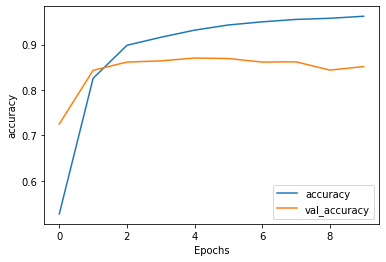

In [0]:
plot_graphs(history, 'accuracy')

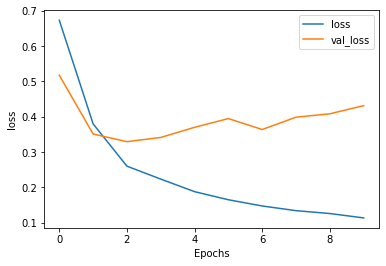

In [0]:
plot_graphs(history, 'loss')

# Excercise


###1. The RNN LSTM model architecture contains the cells, input gate, output gate and forget gate.

- A) True

- B) False

###2. Which gate updates the cell state.

- A) Forget gate

- B) Input gate

- C) Output gate

- D) Draw gate

###3. Complete the LSTM model.
- The model contains 1 LSTM model and embedding layer and a 2 dense layer.

In [0]:
model = tf.keras.______([
    tf.keras.layers.________(___._____, ____),
    tf.keras.layers._________(tf.keras.layers._____(____,  __________=______)),
    tf.keras.layers.______(_____, ________=_______),
    tf.keras.layers.______(____)
])

###4. Create a LSTM model with 2 LSTM layer.
- Also add a dropout layer after the first dense layer.

In [0]:
model = tf.keras.______([
    tf.keras.layers.________(___._____, ____),
    tf.keras.layers._________(tf.keras.layers._____(____,  __________=______)),
    tf.keras.layers.__________(tf.keras.layers._____()),
    tf.keras.layers.______(_____, ________=_______),
    tf.keras.layers.______(____)
])

###5. Compile and Train the model

In [0]:
______.______(___=___.____.____.___(____=___),
              _____=____._____.____.___(___),
              ____=[________])

______ = _________.____(________, _______=_____,
                    _________=_________,
                    ______=___)

# Solution

###1. Question 1
Solution: A- True

###2. Question 2
Solution: B - Input gate

###3. Question 3

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

###4. Question 4

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

###5. Question 5


In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)